# SCM Replication - Becher et al. (BJPS, 2022)

**Focus:**
1. Figure 2 (main SCM + in-space placebos)
2. Leave-one-out sensitivity
3. Time placebo (additional robustness check per Abadie et al.)

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, nnls, differential_evolution
import warnings
warnings.filterwarnings('ignore')
print("Setup complete!")

Setup complete!


In [47]:
## Cache config
from pathlib import Path
import pickle

RECOMPUTE = False  # set True to recompute and overwrite cached objects
SHOW_DONOR_PATHS = False  # set True to overlay donor rr_votes in plots
CACHE_DIR = Path('cache')
CACHE_DIR.mkdir(exist_ok=True)

def save_obj(obj, name):
    with open(CACHE_DIR / f"{name}.pkl", 'wb') as f:
        pickle.dump(obj, f)

def load_obj(name):
    with open(CACHE_DIR / f"{name}.pkl", 'rb') as f:
        return pickle.load(f)

def load_or_none(name):
    try:
        return load_obj(name)
    except FileNotFoundError:
        print(f"Cache miss for {name}, recomputing...")
        return None


## 1. Load Data

In [31]:
DATA_DIR = "replication"

import pyreadstat
dat, _ = pyreadstat.read_dta(f"{DATA_DIR}/CountryEPData.dta")
datIP, _ = pyreadstat.read_dta(f"{DATA_DIR}/CountryEPData_covIP.dta")
dat = dat.merge(datIP, on=['ccode', 'year', 'ep_election'], how='left')

# Keep only the 6 countries used in the paper
KEEP_COUNTRIES = ['Belgium', 'Greece', 'Ireland', 'Italy', 'Netherlands', 'United Kingdom']
dat = dat[dat['country'].isin(KEEP_COUNTRIES)]
dat = dat[dat['ep_election'] != 2019]
dat = dat[dat['year'].isin(dat['ep_election'].unique())]

# Load Westminster data
try:
    westminster = pd.read_csv(f"{DATA_DIR}/westminster.csv")
    westminster = westminster[westminster['year'] <= 2015]
except:
    westminster = None

# Constants
PRE_YEARS = [1979, 1984, 1989, 1994]
POST_YEARS = [1999, 2004, 2009, 2014]
ALL_YEARS = PRE_YEARS + POST_YEARS
TREATED = 'United Kingdom'
DONORS = ['Belgium', 'Greece', 'Ireland', 'Italy', 'Netherlands']

# Reshape outcome to wide format
Y_wide = dat.pivot_table(index='ep_election', columns='country', values='rr_votes', aggfunc='first')
print("Data loaded. Countries:", list(Y_wide.columns))

Data loaded. Countries: ['Belgium', 'Greece', 'Ireland', 'Italy', 'Netherlands', 'United Kingdom']


In [32]:
# Reshape predictors
PREDICTOR_VARS = ['E_eubadIP', 'E_NatDem_satisfiedIP', 'unempIP', 'opencIP',
                  'ch_imp_fns', 'S_uegenIP', 'rightgovIP', 'eu_pos_meanIP', 'migr_inflIP']

X_wide = {}
for var in PREDICTOR_VARS:
    if var in dat.columns:
        X_wide[var] = dat.pivot_table(index='ep_election', columns='country', values=var, aggfunc='first')

print(f"Loaded {len(X_wide)} predictors")

Loaded 9 predictors


## 2. SCM Functions

In [33]:
# Predictor windows (from R code)
PRED_WINDOWS = {
    'E_eubadIP': (1979, 1994),
    'E_NatDem_satisfiedIP': (1979, 1994),
    'unempIP': (1979, 1994),
    'opencIP': (1979, 1994),
    'ch_imp_fns': (1979, 1994),
    'S_uegenIP': (1979, 1994),
    'rightgovIP': (1979, 1994),
    'eu_pos_meanIP': (1979, 1994),
    'migr_inflIP': (1984, 1994),
    'rr_votes': (1994, 1994),
}

def build_predictor_matrix(countries, windows=PRED_WINDOWS):
    """Build predictor matrix X (K predictors × J countries)."""
    rows, names = [], []
    for pred_name, (start_year, end_year) in windows.items():
        if pred_name == 'rr_votes':
            data = Y_wide
        elif pred_name in X_wide:
            data = X_wide[pred_name]
        else:
            continue
        years_in_window = [y for y in data.index if start_year <= y <= end_year]
        if not years_in_window:
            continue
        row = data.loc[years_in_window, countries].mean(axis=0).values
        if not np.any(np.isnan(row)):
            rows.append(row)
            names.append(pred_name)
    return np.array(rows), names

In [34]:
def solve_W_given_V(V, X1, X0):
    """Inner optimization: find country weights W given predictor weights V."""
    sqrt_V = np.sqrt(np.maximum(V, 1e-10))
    X1_w = sqrt_V * X1
    X0_w = sqrt_V.reshape(-1, 1) * X0
    try:
        W, _ = nnls(X0_w, X1_w, maxiter=5000)
    except:
        W = np.ones(X0.shape[1]) / X0.shape[1]
    return W / W.sum() if W.sum() > 1e-10 else np.ones(X0.shape[1]) / X0.shape[1]

def scm_loss_V(V_raw, X1, X0, Y1_pre, Y0_pre):
    """Outer optimization objective: pre-treatment RMSPE."""
    V = np.abs(V_raw)
    V = V / V.sum() if V.sum() > 1e-10 else np.ones_like(V_raw) / len(V_raw)
    W = solve_W_given_V(V, X1, X0)
    Y_synth_pre = Y0_pre @ W
    return np.sqrt(np.mean((Y1_pre - Y_synth_pre)**2))

In [35]:
def run_scm(Y_wide, treated, donors, pre_years, post_years, 
            pred_windows=PRED_WINDOWS, n_seeds=20, verbose=False):
    """
    Run SCM with covariates.
    """
    all_years = pre_years + post_years
    countries = [treated] + donors
    
    # Build and standardize predictor matrix
    X_raw, pred_names = build_predictor_matrix(countries, pred_windows)
    X_mean = X_raw.mean(axis=1, keepdims=True)
    X_std = X_raw.std(axis=1, keepdims=True)
    X_std[X_std < 1e-6] = 1
    X = (X_raw - X_mean) / X_std
    
    X1, X0 = X[:, 0], X[:, 1:]
    K, J = len(pred_names), len(donors)
    
    # Get outcome data
    Y1_pre = Y_wide.loc[pre_years, treated].values
    Y0_pre = Y_wide.loc[pre_years, donors].values
    Y1_all = Y_wide.loc[all_years, treated].values
    Y0_all = Y_wide.loc[all_years, donors].values
    
    # Optimize
    best_loss, best_V, best_W = np.inf, None, None
    
    # Differential evolution
    for seed in range(min(n_seeds, 5)):
        try:
            res = differential_evolution(scm_loss_V, [(0.001, 1.0)]*K,
                                         args=(X1, X0, Y1_pre, Y0_pre),
                                         seed=seed, maxiter=200, tol=1e-6, polish=True)
            if res.fun < best_loss:
                best_loss = res.fun
                best_V = np.abs(res.x) / np.sum(np.abs(res.x))
                best_W = solve_W_given_V(best_V, X1, X0)
        except:
            pass
    
    # L-BFGS-B refinement
    for seed in range(n_seeds):
        np.random.seed(seed * 123 + 456)
        V0 = np.random.dirichlet(np.ones(K) * 0.5)
        try:
            res = minimize(scm_loss_V, V0, args=(X1, X0, Y1_pre, Y0_pre),
                          method='L-BFGS-B', bounds=[(1e-6, 1.0)]*K)
            if res.fun < best_loss:
                best_loss = res.fun
                best_V = np.abs(res.x) / np.sum(np.abs(res.x))
                best_W = solve_W_given_V(best_V, X1, X0)
        except:
            pass
    
    # Compute results
    Y_synth = Y0_all @ best_W
    gaps = Y1_all - Y_synth
    
    if verbose:
        print(f"  RMSPE: {best_loss:.4f}")
    
    return {
        'treated': treated,
        'donors': donors,
        'years': all_years,
        'Y_treat': Y1_all,
        'Y_synth': Y_synth,
        'gaps': gaps,
        'W': best_W,
        'rmspe': best_loss,
        'W_dict': {d: w for d, w in zip(donors, best_W)}
    }

## 3. Main SCM + In-Space Placebos (for Figure 2)

In [36]:
%%time
print("Running main SCM and in-space placebos...")
print("="*50)

all_units = [TREATED] + DONORS
placebo_results = None
results = None

if not RECOMPUTE:
    placebo_results = load_or_none("placebo_results")
    results = load_or_none("results")

if RECOMPUTE or placebo_results is None or results is None:
    placebo_results = []
    for unit in all_units:
        print(f"  {unit}...", end=" ")
        donors_p = [u for u in all_units if u != unit]
        res = run_scm(Y_wide, unit, donors_p, PRE_YEARS, POST_YEARS, n_seeds=5, verbose=True)
        placebo_results.append(res)
    results = next(r for r in placebo_results if r['treated'] == TREATED)
    save_obj(placebo_results, "placebo_results")
    save_obj(results, "results")
else:
    print("Loaded main SCM and in-space placebos from cache.")

print("" + "="*50)
print("MAIN RESULTS")
print("="*50)
print(f"Country weights:")
for d, w in sorted(results['W_dict'].items(), key=lambda x: -x[1]):
    if w > 0.01:
        print(f"  {d}: {w:.2f}")

print(f"Average treatment effect: {np.mean(results['gaps'][4:]):.1f} pp (paper: ~13.5 pp)")


Running main SCM and in-space placebos...
Loaded main SCM and in-space placebos from cache.
MAIN RESULTS
Country weights:
  Netherlands: 0.94
  Ireland: 0.06
Average treatment effect: 12.2 pp (paper: ~13.5 pp)
CPU times: user 2.04 ms, sys: 66 μs, total: 2.1 ms
Wall time: 7.31 ms


## 4. Figure 2

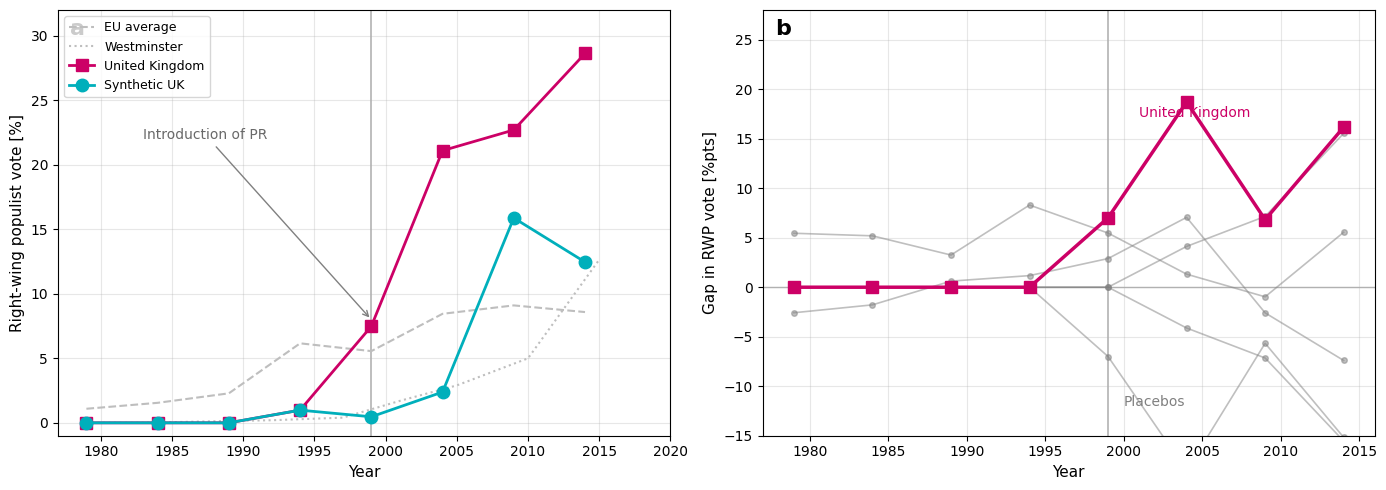

Figure 2 saved!


In [37]:
# EU average
eu_avg = Y_wide[DONORS].mean(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Levels
ax1 = axes[0]
ax1.grid(True, alpha=0.3, zorder=0)
ax1.axvline(1999, color='gray', lw=1.2, alpha=0.6, zorder=1)

ax1.plot(ALL_YEARS, eu_avg.loc[ALL_YEARS], '--', color='#BEBEBE', lw=1.5, label='EU average', zorder=2)
if westminster is not None:
    wm = westminster[westminster['year'].isin(range(1979, 2016))]
    ax1.plot(wm['year'], wm['westminster_vote'], ':', color='#BEBEBE', lw=1.5, label='Westminster', zorder=2)
ax1.plot(ALL_YEARS, results['Y_treat'], 's-', color='#CC0066', lw=2, ms=9, label='United Kingdom', zorder=3)
ax1.plot(ALL_YEARS, results['Y_synth'], 'o-', color='#00AFBB', lw=2, ms=9, label='Synthetic UK', zorder=3)

ax1.annotate('Introduction of PR', xy=(1999, 8), xytext=(1983, 22),
            arrowprops=dict(arrowstyle='->', color='gray'), fontsize=10, color='dimgray')

ax1.set_xlim(1977, 2020)
ax1.set_ylim(-1, 32)
ax1.set_xlabel('Year', fontsize=11)
ax1.set_ylabel('Right-wing populist vote [%]', fontsize=11)
ax1.legend(loc='upper left', fontsize=9)
ax1.text(0.02, 0.98, 'a', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top')

# Panel B: Gaps with placebos
ax2 = axes[1]
ax2.grid(True, alpha=0.3, zorder=0)
ax2.axvline(1999, color='gray', lw=1.2, alpha=0.6, zorder=1)
ax2.axhline(0, color='gray', lw=1.0, alpha=0.6, zorder=1)

for r in placebo_results:
    if r['treated'] != TREATED:
        ax2.plot(ALL_YEARS, r['gaps'], 'o-', color='gray', lw=1.2, ms=4, alpha=0.5, zorder=2)

ax2.plot(ALL_YEARS, results['gaps'], 's-', color='#CC0066', lw=2.5, ms=9, zorder=3)

ax2.set_xlim(1977, 2016)
ax2.set_ylim(-15, 28)
ax2.set_xlabel('Year', fontsize=11)
ax2.set_ylabel('Gap in RWP vote [%pts]', fontsize=11)
ax2.text(0.02, 0.98, 'b', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top')
ax2.text(2001, results['gaps'][-1]+1, 'United Kingdom', color='#CC0066', fontsize=10)
ax2.text(2000, -12, 'Placebos', color='gray', fontsize=10)

plt.tight_layout()
plt.savefig('Figure2.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure 2 saved!")

## 5. Leave-One-Out Analysis

In [38]:
%%time
print("Running leave-one-out analysis...")
print("="*50)

loo_results = None
if not RECOMPUTE:
    loo_results = load_or_none("loo_results")

if RECOMPUTE or loo_results is None:
    loo_results = []
    for excluded in DONORS:
        print(f"  Excluding {excluded}...", end=" ")
        donors_loo = [d for d in DONORS if d != excluded]
        res = run_scm(Y_wide, TREATED, donors_loo, PRE_YEARS, POST_YEARS, n_seeds=15, verbose=True)
        res['excluded'] = excluded
        loo_results.append(res)
    save_obj(loo_results, "loo_results")
else:
    print("Loaded leave-one-out results from cache.")

print("Leave-One-Out Summary:")
print("-"*50)
for res in loo_results:
    avg = np.mean(res['gaps'][4:])
    print(f"  excl. {res['excluded']:12s}: avg effect = {avg:.1f} pp")


Running leave-one-out analysis...
Loaded leave-one-out results from cache.
Leave-One-Out Summary:
--------------------------------------------------
  excl. Belgium     : avg effect = 12.2 pp
  excl. Greece      : avg effect = 12.2 pp
  excl. Ireland     : avg effect = 11.7 pp
  excl. Italy       : avg effect = 11.7 pp
  excl. Netherlands : avg effect = 14.7 pp
CPU times: user 1.59 ms, sys: 0 ns, total: 1.59 ms
Wall time: 1.93 ms


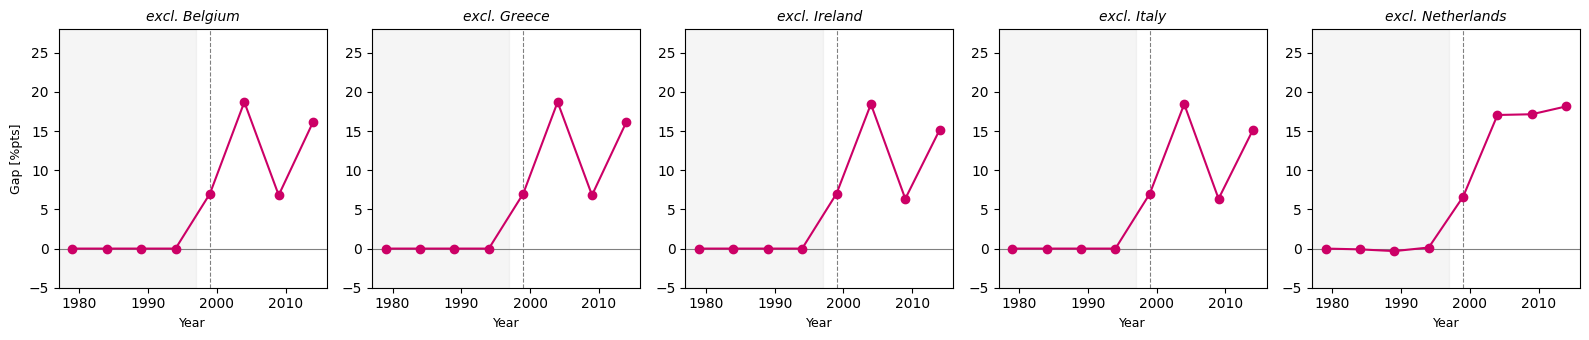

In [39]:
# Leave-one-out plot
fig, axes = plt.subplots(1, 5, figsize=(16, 3.5))

for i, res in enumerate(loo_results):
    ax = axes[i]
    ax.axhline(0, color='gray', lw=0.8)
    ax.axvline(1999, color='gray', lw=0.8, ls='--')
    ax.axvspan(1977, 1997, alpha=0.08, color='gray')
    ax.plot(res['years'], res['gaps'], 'o-', color='#CC0066', lw=1.5, ms=6)
    ax.set_title(f"excl. {res['excluded']}", fontsize=10, style='italic')
    ax.set_ylim(-5, 28)
    ax.set_xlim(1977, 2016)
    ax.set_xlabel('Year', fontsize=9)
    if i == 0:
        ax.set_ylabel('Gap [%pts]', fontsize=9)

plt.tight_layout()
plt.savefig('Leave_one_out.png', dpi=150, bbox_inches='tight')
plt.show()

## Leave-one-out panels (each exclusion)

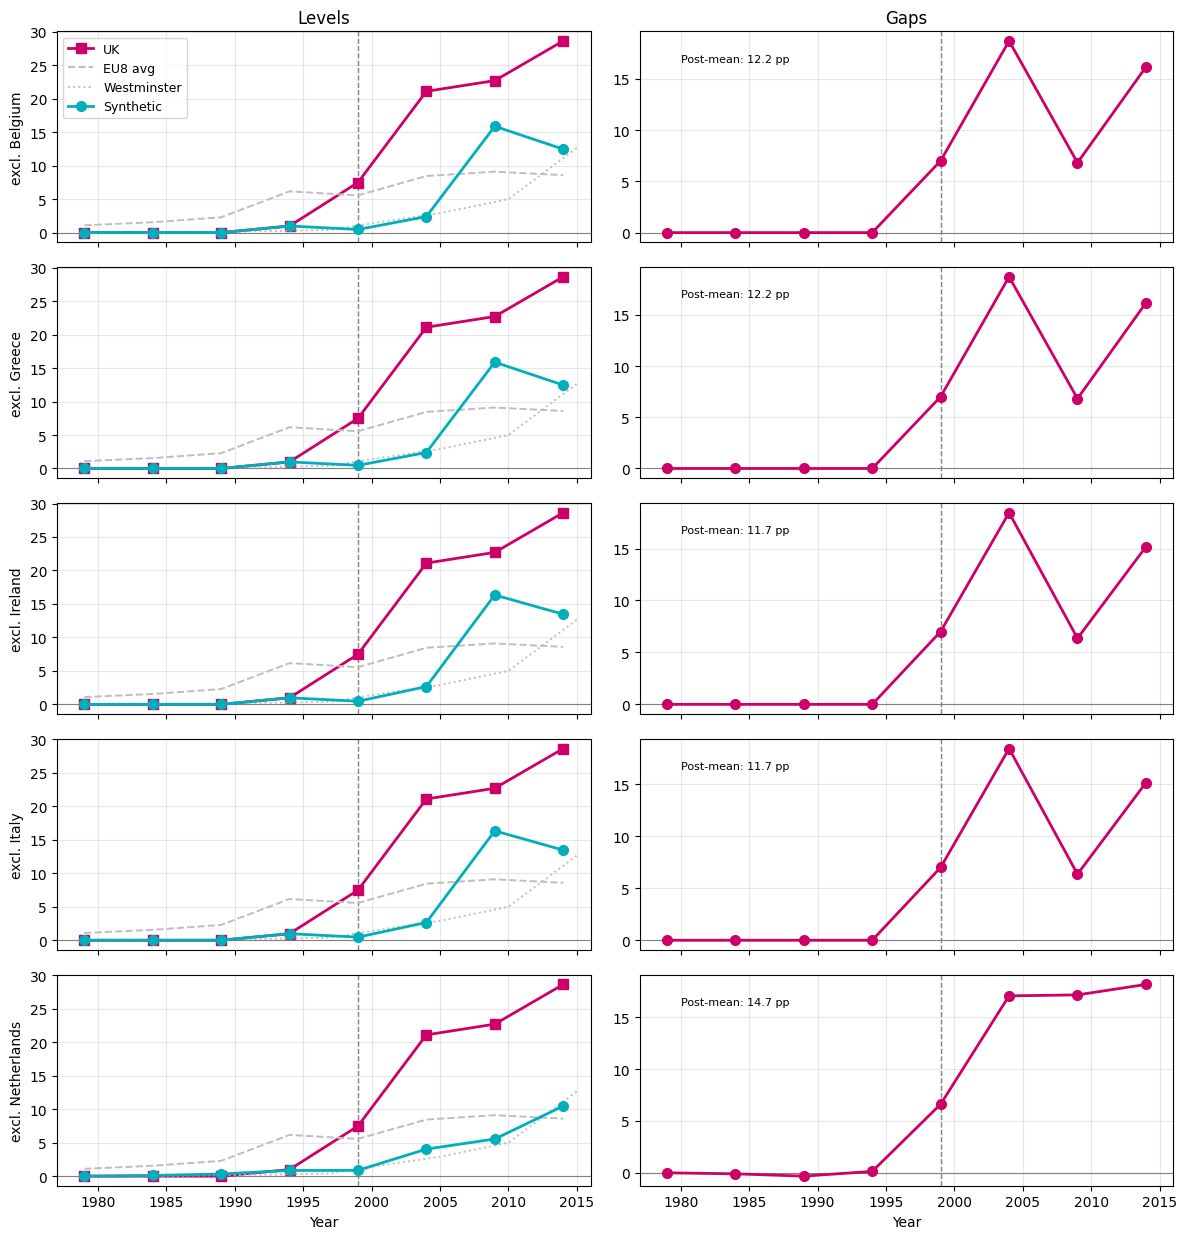

In [48]:
# Leave-one-out panels: levels and gaps per exclusion
n = len(loo_results)
fig, axes = plt.subplots(n, 2, figsize=(12, 2.5*n), sharex='col')
if n == 1:
    axes = [axes]

for idx, res in enumerate(loo_results):
    years = res['years']
    # Levels
    axL = axes[idx][0]
    axL.axvline(1999, color='gray', lw=1.0, ls='--')
    axL.axhline(0, color='gray', lw=0.8)
    axL.plot(years, res['Y_treat'], 's-', color='#CC0066', lw=2, ms=7, label='UK')
    # EU average (fixed donor set)
    if SHOW_DONOR_PATHS:
        for j, donor in enumerate(DONORS):
            donor_path = Y_wide.loc[years, donor]
            label = 'Donor rr_votes' if (idx == 0 and j == 0) else None
            axL.plot(years, donor_path, '-', color='gray', lw=1, alpha=0.4, label=label)
    axL.plot(years, eu_avg.loc[years], '--', color='#BEBEBE', lw=1.4, label='EU8 avg')
    if westminster is not None:
        axL.plot(westminster['year'], westminster['westminster_vote'], ':', color='#BEBEBE', lw=1.4, label='Westminster')
    axL.plot(years, res['Y_synth'], 'o-', color='#00AFBB', lw=2, ms=7, label='Synthetic')
    if idx == 0:
        axL.legend(fontsize=9)
    axL.set_ylabel(f"excl. {res['excluded']}")
    axL.set_xlim(1977, 2016)
    axL.grid(True, alpha=0.3)

    # Gaps
    axG = axes[idx][1]
    axG.axvline(1999, color='gray', lw=1.0, ls='--')
    axG.axhline(0, color='gray', lw=0.8)
    axG.plot(years, res['gaps'], 'o-', color='#CC0066', lw=2, ms=7)
    axG.set_xlim(1977, 2016)
    axG.grid(True, alpha=0.3)
    avg_gap = np.mean(res['gaps'][4:])
    axG.text(1980, axG.get_ylim()[1]*0.85, f"Post-mean: {avg_gap:.1f} pp", fontsize=8)

axes[-1][0].set_xlabel('Year')
axes[-1][1].set_xlabel('Year')
axes[0][0].set_title('Levels')
axes[0][1].set_title('Gaps')
plt.tight_layout()
plt.savefig('Leave_one_out_panels.png', dpi=150, bbox_inches='tight')
plt.show()


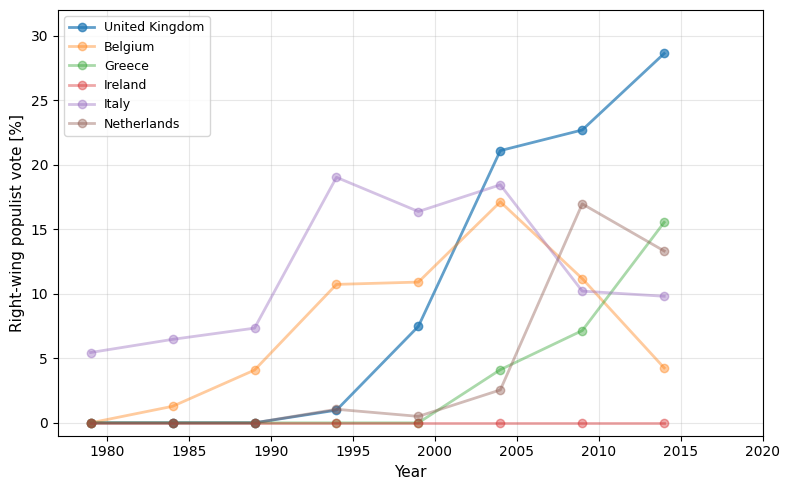

In [41]:
# spagetti plot of the rr_votes of each country
fig, ax = plt.subplots(figsize=(8, 5))
ax.grid(True, alpha=0.3, zorder=0)
for country in all_units:
    path = Y_wide.loc[ALL_YEARS, country]
    ax.plot(
        ALL_YEARS,
        path,
        "o-",
        lw=2,
        ms=6,
        label=country,
        alpha=0.7 if country == TREATED else 0.4,
    )
ax.set_xlim(1977, 2020)
ax.set_ylim(-1, 32)
ax.set_xlabel("Year", fontsize=11)
ax.set_ylabel("Right-wing populist vote [%]", fontsize=11)
ax.legend(loc="upper left", fontsize=9)
plt.tight_layout()
plt.savefig("Spaghetti_plot.png", dpi=150, bbox_inches="tight")
plt.show()


## 6. Time Placebo (Backdating Treatment to 1989)

**Not in the paper** - additional robustness check based on Abadie et al. (2010).

Idea: Pretend treatment happened in 1989. If the effect is ~0, it confirms no pre-existing trends.

In [42]:
# Adjusted predictor windows for 1989 "treatment"
PRED_WINDOWS_1989 = {
    'E_eubadIP': (1979, 1984),
    'E_NatDem_satisfiedIP': (1979, 1984),
    'unempIP': (1979, 1984),
    'opencIP': (1979, 1984),
    'ch_imp_fns': (1979, 1984),
    'S_uegenIP': (1979, 1984),
    'rightgovIP': (1979, 1984),
    'eu_pos_meanIP': (1979, 1984),
    'rr_votes': (1984, 1984),
}

print("Running time placebo (fake treatment in 1989)...")

time_placebo = None
if not RECOMPUTE:
    time_placebo = load_or_none("time_placebo")

if RECOMPUTE or time_placebo is None:
    time_placebo = run_scm(
        Y_wide, TREATED, DONORS,
        pre_years=[1979, 1984],
        post_years=[1989, 1994],
        pred_windows=PRED_WINDOWS_1989,
        n_seeds=15,
        verbose=True
    )
    save_obj(time_placebo, "time_placebo")

avg_placebo = np.mean(time_placebo['gaps'][2:])
print(f"Time placebo effect: {avg_placebo:.1f} pp (should be ~0)")


Running time placebo (fake treatment in 1989)...
Time placebo effect: 0.5 pp (should be ~0)


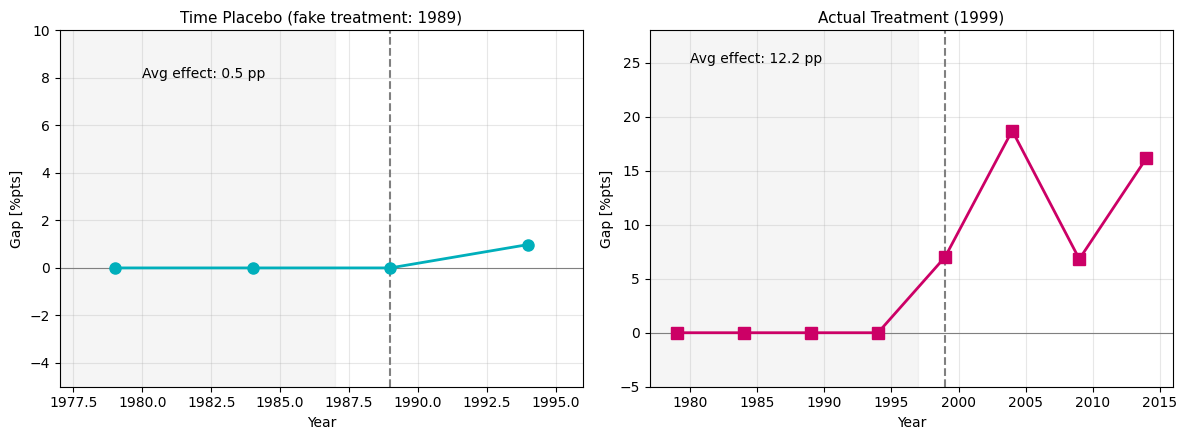

In [43]:
# Time placebo plot (side-by-side comparison)
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# Panel A: Time placebo
ax1 = axes[0]
ax1.axhline(0, color='gray', lw=0.8)
ax1.axvline(1989, color='gray', lw=1.5, ls='--')
ax1.axvspan(1977, 1987, alpha=0.08, color='gray')
ax1.plot(time_placebo['years'], time_placebo['gaps'], 'o-', color='#00AFBB', lw=2, ms=8)
ax1.set_xlim(1977, 1996)
ax1.set_ylim(-5, 10)
ax1.set_title('Time Placebo (fake treatment: 1989)', fontsize=11)
ax1.set_xlabel('Year')
ax1.set_ylabel('Gap [%pts]')
ax1.grid(True, alpha=0.3)
ax1.text(1980, 8, f'Avg effect: {avg_placebo:.1f} pp', fontsize=10)

# Panel B: Actual treatment
ax2 = axes[1]
ax2.axhline(0, color='gray', lw=0.8)
ax2.axvline(1999, color='gray', lw=1.5, ls='--')
ax2.axvspan(1977, 1997, alpha=0.08, color='gray')
ax2.plot(results['years'], results['gaps'], 's-', color='#CC0066', lw=2, ms=8)
ax2.set_xlim(1977, 2016)
ax2.set_ylim(-5, 28)
ax2.set_title('Actual Treatment (1999)', fontsize=11)
ax2.set_xlabel('Year')
ax2.set_ylabel('Gap [%pts]')
ax2.grid(True, alpha=0.3)
ax2.text(1980, 25, f'Avg effect: {np.mean(results["gaps"][4:]):.1f} pp', fontsize=10)

plt.tight_layout()
plt.savefig('Time_placebo.png', dpi=150, bbox_inches='tight')
plt.show()

## Figure 1 (Time placebo 1989)

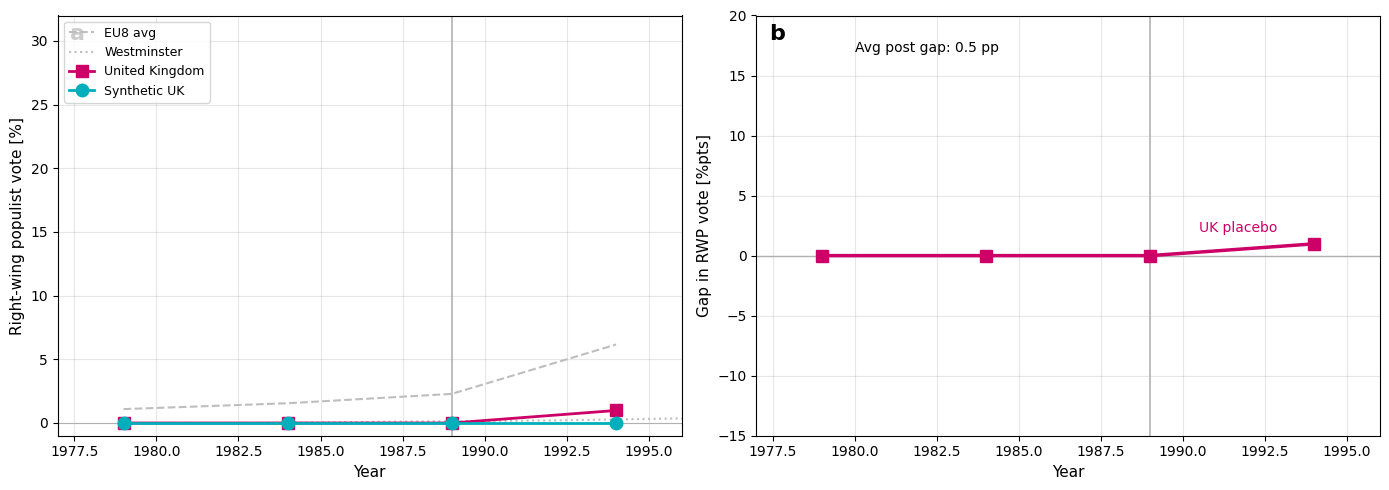

In [49]:
# Figure 1 style plot for time placebo (1989)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Levels
ax1 = axes[0]
ax1.grid(True, alpha=0.3, zorder=0)
ax1.axvline(1989, color='gray', lw=1.2, alpha=0.6, zorder=1)
ax1.axhline(0, color='gray', lw=0.8, alpha=0.6, zorder=1)
ax1.plot(time_placebo['years'], eu_avg.loc[time_placebo['years']], '--', color='#BEBEBE', lw=1.5, label='EU8 avg', zorder=2)
if westminster is not None:
    ax1.plot(westminster['year'], westminster['westminster_vote'], ':', color='#BEBEBE', lw=1.5, label='Westminster', zorder=2)
if SHOW_DONOR_PATHS:
    for j, donor in enumerate(DONORS):
        donor_path = Y_wide.loc[time_placebo['years'], donor]
        label = 'Donor rr_votes' if j == 0 else None
        ax1.plot(time_placebo['years'], donor_path, '-', color='gray', lw=1, alpha=0.4, label=label, zorder=2)
ax1.plot(time_placebo['years'], time_placebo['Y_treat'], 's-', color='#CC0066', lw=2, ms=9, label='United Kingdom', zorder=3)
ax1.plot(time_placebo['years'], time_placebo['Y_synth'], 'o-', color='#00AFBB', lw=2, ms=9, label='Synthetic UK', zorder=3)
ax1.set_xlim(1977, 1996)
ax1.set_ylim(-1, 32)
ax1.set_xlabel('Year', fontsize=11)
ax1.set_ylabel('Right-wing populist vote [%]', fontsize=11)
ax1.legend(loc='upper left', fontsize=9)
ax1.text(0.02, 0.98, 'a', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top')

# Panel B: Gaps
ax2 = axes[1]
ax2.grid(True, alpha=0.3, zorder=0)
ax2.axvline(1989, color='gray', lw=1.2, alpha=0.6, zorder=1)
ax2.axhline(0, color='gray', lw=1.0, alpha=0.6, zorder=1)
ax2.plot(time_placebo['years'], time_placebo['gaps'], 's-', color='#CC0066', lw=2.5, ms=9, zorder=3)
ax2.set_xlim(1977, 1996)
ax2.set_ylim(-15, 20)
ax2.set_xlabel('Year', fontsize=11)
ax2.set_ylabel('Gap in RWP vote [%pts]', fontsize=11)
ax2.text(0.02, 0.98, 'b', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top')
ax2.text(1990.5, time_placebo['gaps'][-1]+1, 'UK placebo', color='#CC0066', fontsize=10)
ax2.text(1980, 17, f"Avg post gap: {np.mean(time_placebo['gaps'][2:]):.1f} pp", fontsize=10)

plt.tight_layout()
plt.savefig('Figure1_time_placebo.png', dpi=150, bbox_inches='tight')
plt.show()


## 7. Summary

In [44]:
print("="*60)
print("SUMMARY")
print("="*60)

print("\n1. MAIN RESULT (Figure 2):")
print(f"   Treatment effect: {np.mean(results['gaps'][4:]):.1f} pp (paper: ~13.5 pp)")
print(f"   Main donor: {max(results['W_dict'], key=results['W_dict'].get)}")

print("\n2. LEAVE-ONE-OUT:")
loo_effects = [np.mean(r['gaps'][4:]) for r in loo_results]
print(f"   Effect range: [{min(loo_effects):.1f}, {max(loo_effects):.1f}] pp")
print(f"   All positive: {all(e > 0 for e in loo_effects)}")

print("\n3. TIME PLACEBO (not in paper, per Abadie et al.):")
print(f"   Placebo effect: {avg_placebo:.1f} pp (should be ~0)")

print("\n" + "="*60)

SUMMARY

1. MAIN RESULT (Figure 2):
   Treatment effect: 12.2 pp (paper: ~13.5 pp)
   Main donor: Netherlands

2. LEAVE-ONE-OUT:
   Effect range: [11.7, 14.7] pp
   All positive: True

3. TIME PLACEBO (not in paper, per Abadie et al.):
   Placebo effect: 0.5 pp (should be ~0)



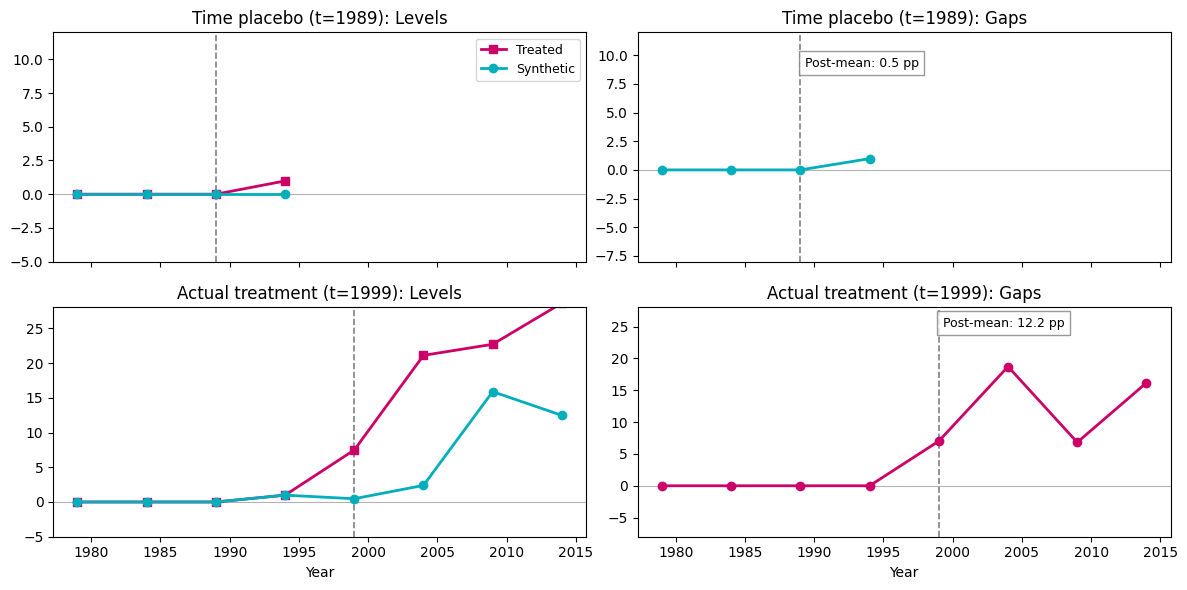

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
configs = [
    ("Time placebo (t=1989)", time_placebo, 1989, (-5, 12)),
    ("Actual treatment (t=1999)", results, 1999, (-5, 28)),
]
for row, (title, res, t_year, ylims) in enumerate(configs):
    # Levels
    ax = axes[row, 0]
    ax.axvline(t_year, color="gray", ls="--", lw=1.2)
    ax.axhline(0, color="gray", lw=0.8, alpha=0.6)
    ax.plot(res["years"], res["Y_treat"], "s-", color="#CC0066", lw=2, ms=6, label="Treated")
    ax.plot(res["years"], res["Y_synth"], "o-", color="#00AFBB", lw=2, ms=6, label="Synthetic")
    ax.set_title(f"{title}: Levels")
    ax.set_ylim(ylims)
    if row == 0: ax.legend(fontsize=9)

    # Gaps
    ax = axes[row, 1]
    ax.axvline(t_year, color="gray", ls="--", lw=1.2)
    ax.axhline(0, color="gray", lw=0.8, alpha=0.6)
    ax.plot(res["years"], res["gaps"], "o-", color="#00AFBB" if row == 0 else "#CC0066", lw=2, ms=6)
    ax.set_title(f"{title}: Gaps")
    ax.set_ylim(-8, ylims[1])
    post_mask = [y >= t_year for y in res["years"]]
    post_mean = res["gaps"][post_mask].mean()
    ax.text(t_year+0.3, ylims[1]-3, f"Post-mean: {post_mean:.1f} pp", fontsize=9, bbox=dict(fc="white", ec="gray", alpha=0.8))
axes[1,0].set_xlabel("Year"); axes[1,1].set_xlabel("Year")
plt.tight_layout()
plt.savefig("time_placebo_comparison.png", dpi=150, bbox_inches="tight")
plt.show()
